In [2]:
import warnings
from datetime import date
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('white')

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Plot of Close Price

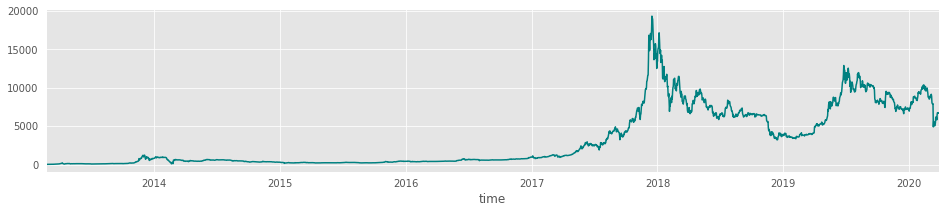

In [4]:
# Load data

data = pd.read_csv("BTC_processed.csv")

# data['signal'] = (data['buy_signal'] - data['sell_signal'] + data['hold_signal'])
# data = data.drop(['hold_signal', 'buy_signal', 'sell_signal', 'MFI'], axis = 1)
# data.head()

data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time', drop = True)
data = data[~data.index.duplicated(keep='first')]

# log price
data_price = data['close']
data_price.head()
data_price.plot(y='close', color='teal', figsize=(16,3))

## Seasonality Decomposition of Close Price

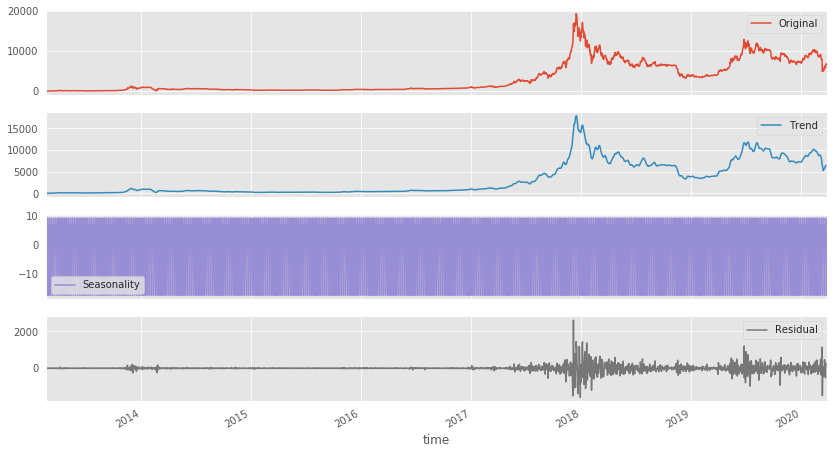

In [5]:
components = tsa.seasonal_decompose(data_price, model='additive')

ts = (data_price.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8));

## Log Price

In [6]:
data_price_log = np.log(data_price)

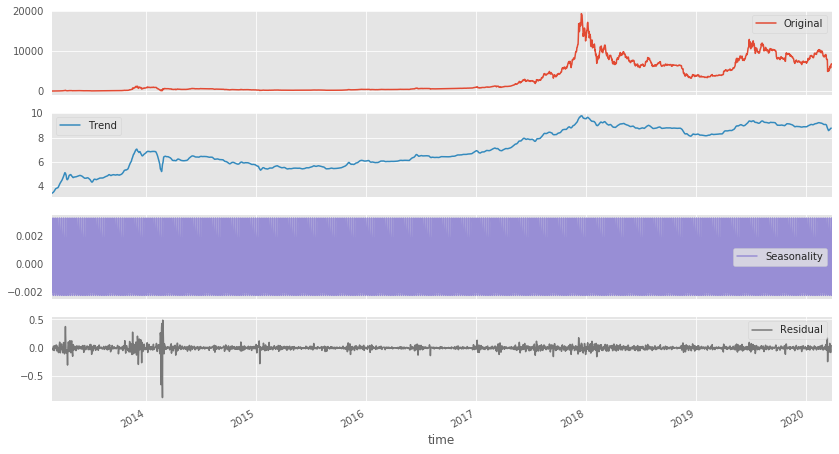

In [7]:
components = tsa.seasonal_decompose(data_price_log, model='additive')

ts = (data_price.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8));

## Unit-root test

Text(0, 0.5, 'Log, Diff')

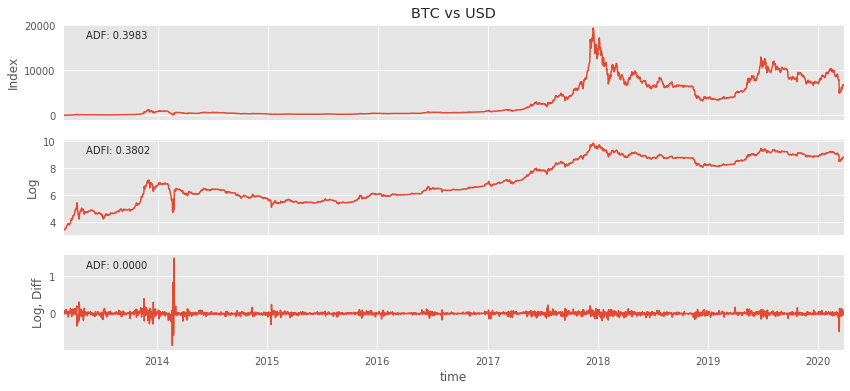

In [8]:
data_price_log_diff = data_price_log.diff().dropna()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14,6))

data_price.plot(ax=axes[0], title='BTC vs USD')
axes[0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(data_price.dropna())[1]:.4f}', transform=axes[0].transAxes)
axes[0].set_ylabel('Index')

data_price_log.plot(ax=axes[1], sharex=axes[0])
axes[1].text(x=.03, y=.85, s=f'ADFl: {tsa.adfuller(data_price_log.dropna())[1]:.4f}', transform=axes[1].transAxes)
axes[1].set_ylabel('Log')

data_price_log_diff.plot(ax=axes[2], sharex=axes[0])
axes[2].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(data_price_log_diff.dropna())[1]:.4f}', transform=axes[2].transAxes)
axes[2].set_ylabel('Log, Diff')

Therefore, we need to use diff 1, i.e. data_price_log_diff

## Correlogram of the log difference of the close price

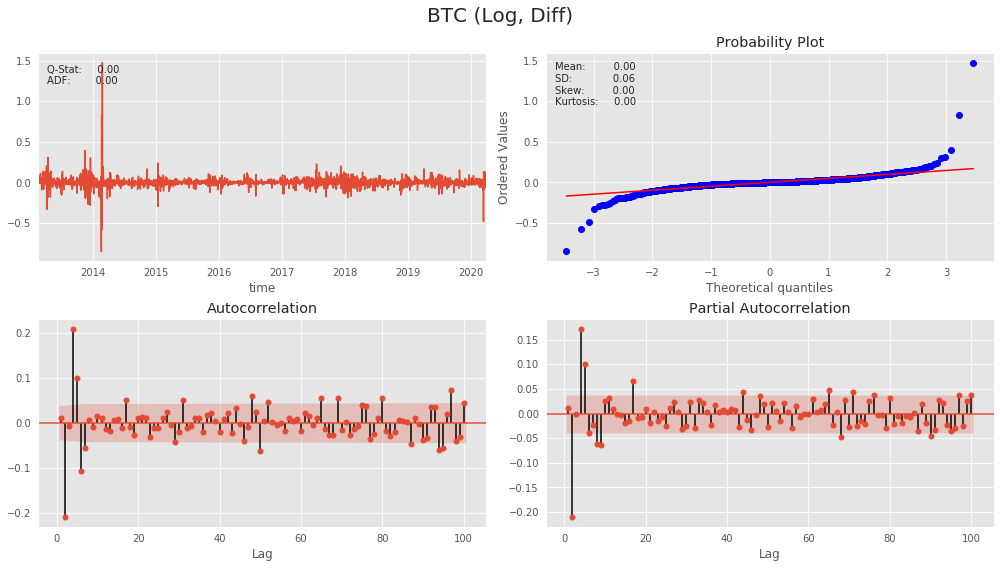

In [9]:
plot_correlogram(data_price_log_diff, lags=100, title='BTC (Log, Diff)')

BTC's returns may be regarded as approximately normally distributed but with strong fat tails. ACF shows distinctive positve autocorrelation patterns at lag 4, 5, and distinctive negative autocorrelation patterns at lag 2 and 6. PACF shows distinctive positve autocorrelation patterns at lag 4, 5, and distinctive negative autocorrelation patterns at lag 2.

## Find the suitable ARMA model to predict the 1-day forward Return

In [10]:
train_size = int(len(data_price_log_diff) * 0.7 )
train_size

1814

In [23]:
test_results = {}
y_true = data_price_log_diff.iloc[train_size:]
for p in range(7):
    for q in range(7):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(data_price_log_diff)):
            train_set = data_price_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        test_results[(p, q)] = [rmse,
                                np.mean(aic),
                                np.mean(bic),
                                convergence_error,
                                stationarity_error]

0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5


In [24]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']
test_results.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35 entries, (0, 1) to (5, 5)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          35 non-null     float64
 1   AIC           35 non-null     float64
 2   BIC           35 non-null     float64
 3   convergence   35 non-null     float64
 4   stationarity  35 non-null     float64
dtypes: float64(5)
memory usage: 1.6 KB


## Heatmap for the RMSEs of all ARMA models

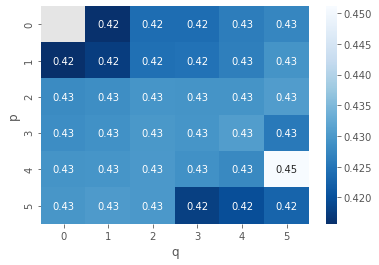

In [26]:

test_results.dropna()
sns.heatmap(test_results.RMSE.unstack().mul(10), fmt='.2', annot=True, cmap='Blues_r');

## Heatmap for the BICs of all ARMA models

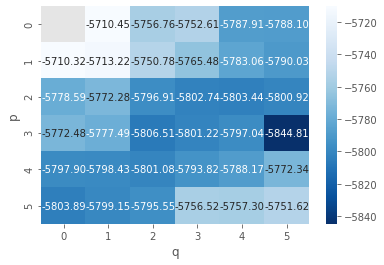

In [27]:
sns.heatmap(test_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues_r');